In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
pd.set_option('max_columns', 5000)
sns.set_style('darkgrid')
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import DBSCAN

import optuna
from functools import partial


sns.set(rc={'figure.figsize':(12,10)})

In [31]:
data = pd.read_excel('IMDb_database.xlsx')
data.head()

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84,2428474,534858444,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...
1,2,The Lord of the Rings: The Return of the King,2003,PG-13,201 min,"Action, Adventure, Drama",8.9,94,1715249,377845905,https://imdb.com/title/tt0167260/,Gandalf and Aragorn lead the World of Men agai...
2,3,Inception,2010,PG-13,148 min,"Action, Adventure, Sci-Fi",8.8,74,2179206,292576195,https://imdb.com/title/tt1375666/,A thief who steals corporate secrets through t...
3,4,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178 min,"Action, Adventure, Drama",8.8,92,1736538,315544750,https://imdb.com/title/tt0120737/,A meek Hobbit from the Shire and eight compani...
4,5,The Mountain II,2016,,135 min,"Action, Drama, War",8.7,,106888,,https://imdb.com/title/tt5813916/,In a desolate war zone where screams of the in...


In [3]:
data.describe()

,Rank,Year,Rating,Votes
count,17483.000000,17483.000000,17483.000000,1.748300e+04
mean,757.889950,2002.676028,6.718286,1.358193e+05
std,665.311836,15.738938,0.954680,1.830410e+05
min,1.000000,1920.000000,1.000000,2.501600e+04
25%,233.000000,1997.000000,6.200000,4.090300e+04
50%,576.000000,2007.000000,6.800000,7.180000e+04
75%,1094.000000,2014.000000,7.400000,1.497080e+05
max,3015.000000,2021.000000,9.300000,2.474457e+06


In [32]:
m = data['Metascore'].unique()
m[4] == ' '

True

In [33]:
data['Metascore'] = data['Metascore'].replace(' ',np.nan)
data['Certificate'] = data['Certificate'].replace(' ',np.nan)
data['Gross'] = data['Gross'].replace(' ',np.nan)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         17483 non-null  int64  
 1   Title        17483 non-null  object 
 2   Year         17483 non-null  int64  
 3   Certificate  17368 non-null  object 
 4   Runtime      17483 non-null  object 
 5   Genre        17483 non-null  object 
 6   Rating       17483 non-null  float64
 7   Metascore    7521 non-null   float64
 8   Votes        17483 non-null  int64  
 9   Gross        15234 non-null  float64
 10  URL          17483 non-null  object 
 11  Intro        17483 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1.6+ MB


In [35]:
data.corr(method='pearson')

,Rank,Year,Rating,Metascore,Votes,Gross
Rank,1.000000,0.195451,-0.544336,-0.277287,-0.265721,-0.142131
Year,0.195451,1.000000,-0.274793,-0.315174,0.051999,0.124838
Rating,-0.544336,-0.274793,1.000000,0.526936,0.360469,0.097617
Metascore,-0.277287,-0.315174,0.526936,1.000000,0.166493,0.017112
Votes,-0.265721,0.051999,0.360469,0.166493,1.000000,0.588034
Gross,-0.142131,0.124838,0.097617,0.017112,0.588034,1.000000


array([[<AxesSubplot:title={'center':'Rank'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Metascore'}>],
       [<AxesSubplot:title={'center':'Votes'}>,
        <AxesSubplot:title={'center':'Gross'}>]], dtype=object)

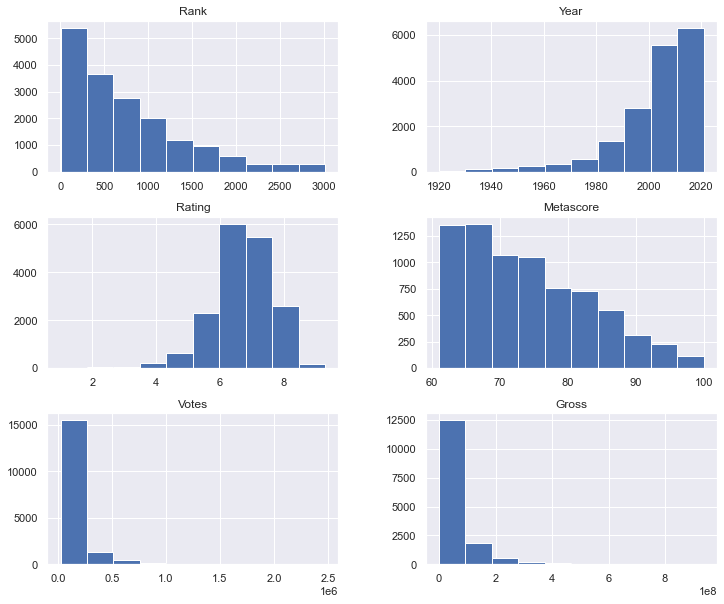

In [36]:
data.hist()

In [37]:
# get the movie_time_min from Runtime with apply mehtod
x = lambda x: int(x.split(' ')[0])
data['Movie_time_min'] = data['Runtime'].apply(x)
data.head(1)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro,Movie_time_min
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84.0,2428474,534858444.0,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...,152


In [38]:
# get the all genres
g = data['Genre'].unique()
l = []
for i in range(len(g)):
    tmp = g[i].split(',')
    for j in tmp:
        if j not in l:
            l.append(j)
l = [x.strip() for x in l]
l = set(l)
len(l)

21

In [39]:
# add column for each genre
tmp = [x.replace(' ','').split(',') for x in data['Genre'].tolist()]
for i in l:
    data[i] = 0

for i in range(13,34):
    for j in range(len(tmp)):
        if data.columns[i] in tmp[j]:
            data.iloc[j,i] = 1
        else:
            data.iloc[j,i] = 0
data.sample(5)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro,Movie_time_min,Biography,Music,Comedy,Animation,Film-Noir,Mystery,Sport,History,Adventure,Crime,War,Thriller,Drama,Western,Musical,Sci-Fi,Romance,Action,Fantasy,Family,Horror
1828,258,Back to the Future Part III,1990,PG,118 min,"Adventure, Comedy, Sci-Fi",7.4,NaN,423007,87727583.0,https://imdb.com/title/tt0099088/,"Stranded in 1955, Marty McFly learns about the...",118,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
11304,50,Army of Darkness,1992,R,81 min,"Comedy, Horror",7.5,NaN,168918,11502976.0,https://imdb.com/title/tt0106308/,A sardonic hardware store clerk is accidentall...,81,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5364,1929,Seed of Chucky,2004,R,87 min,"Comedy, Fantasy, Horror",4.8,NaN,42608,17083732.0,https://imdb.com/title/tt0387575/,Chucky and Tiffany are resurrected by their in...,87,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
7500,867,The Guilty,2018,R,85 min,"Crime, Drama, Thriller",7.5,83.0,53021,207140.0,https://imdb.com/title/tt6742252/,A police officer assigned alarm dispatch duty ...,85,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0
13883,828,A Little Bit of Heaven,2011,PG-13,106 min,"Comedy, Drama, Fantasy",6.3,NaN,28350,10011.0,https://imdb.com/title/tt1440161/,An irreverent young woman who uses her humor t...,106,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [12]:
data.describe()

,Rank,Year,Rating,Metascore,Votes,Gross,Movie_time_min,Sci-Fi,Thriller,Romance,...,Biography,Drama,Music,Musical,Family,Comedy,Film-Noir,Western,War,Crime
count,17483.000000,17483.000000,17483.000000,7521.000000,1.748300e+04,1.523400e+04,17483.000000,17483.000000,17483.000000,17483.000000,...,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000
mean,757.889950,2002.676028,6.718286,73.967558,1.358193e+05,5.749955e+07,111.065035,0.093176,0.151118,0.133844,...,0.080764,0.520906,0.025510,0.012698,0.061260,0.362695,0.005434,0.006807,0.014929,0.234170
std,665.311836,15.738938,0.954680,9.465180,1.830410e+05,7.897623e+07,21.059282,0.290688,0.358174,0.340495,...,0.272480,0.499577,0.157674,0.111971,0.239813,0.480792,0.073516,0.082223,0.121271,0.423491
min,1.000000,1920.000000,1.000000,61.000000,2.501600e+04,4.410000e+02,45.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,233.000000,1997.000000,6.200000,66.000000,4.090300e+04,8.586380e+06,97.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,576.000000,2007.000000,6.800000,72.000000,7.180000e+04,3.259893e+07,107.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1094.000000,2014.000000,7.400000,81.000000,1.497080e+05,7.158392e+07,121.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3015.000000,2021.000000,9.300000,100.000000,2.474457e+06,9.366622e+08,321.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'PG-13'),
  Text(1, 0, 'R'),
  Text(2, 0, 'PG'),
  Text(3, 0, 'Not Rated'),
  Text(4, 0, 'Passed'),
  Text(5, 0, 'TV-MA'),
  Text(6, 0, 'TV-14'),
  Text(7, 0, 'G'),
  Text(8, 0, 'Approved'),
  Text(9, 0, 'M'),
  Text(10, 0, 'TV-PG'),
  Text(11, 0, 'M/PG'),
  Text(12, 0, 'GP'),
  Text(13, 0, 'Unrated'),
  Text(14, 0, 'NC-17'),
  Text(15, 0, 'TV-G'),
  Text(16, 0, 'X')])

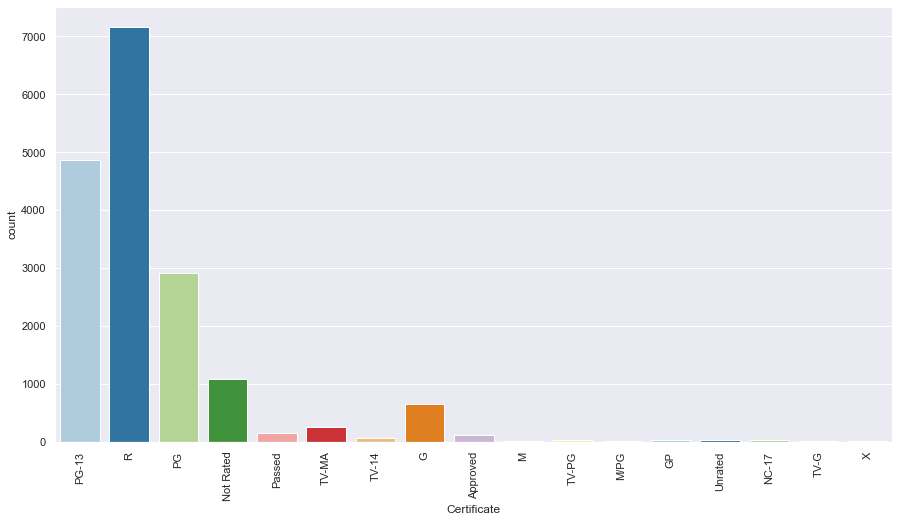

In [13]:
# countplot for certificate
plt.figure(figsize = (15,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Certificate', data= data, palette='Paired')
plt.xticks(rotation= 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '1.1'),
  Text(2, 0, '1.2'),
  Text(3, 0, '1.4'),
  Text(4, 0, '1.8'),
  Text(5, 0, '1.9'),
  Text(6, 0, '2.0'),
  Text(7, 0, '2.1'),
  Text(8, 0, '2.2'),
  Text(9, 0, '2.4'),
  Text(10, 0, '2.5'),
  Text(11, 0, '2.7'),
  Text(12, 0, '2.8'),
  Text(13, 0, '2.9'),
  Text(14, 0, '3.0'),
  Text(15, 0, '3.1'),
  Text(16, 0, '3.2'),
  Text(17, 0, '3.3'),
  Text(18, 0, '3.4'),
  Text(19, 0, '3.5'),
  Text(20, 0, '3.6'),
  Text(21, 0, '3.7'),
  Text(22, 0, '3.8'),
  Text(23, 0, '3.9'),
  Text(24, 0, '4.0'),
  Text(25, 0, '4.1'),
  Text(26, 0, '4.2'),
  Text(27, 0, '4.3'),
  Text(28, 0, '4.4'),
  Text(29, 0, '4.5

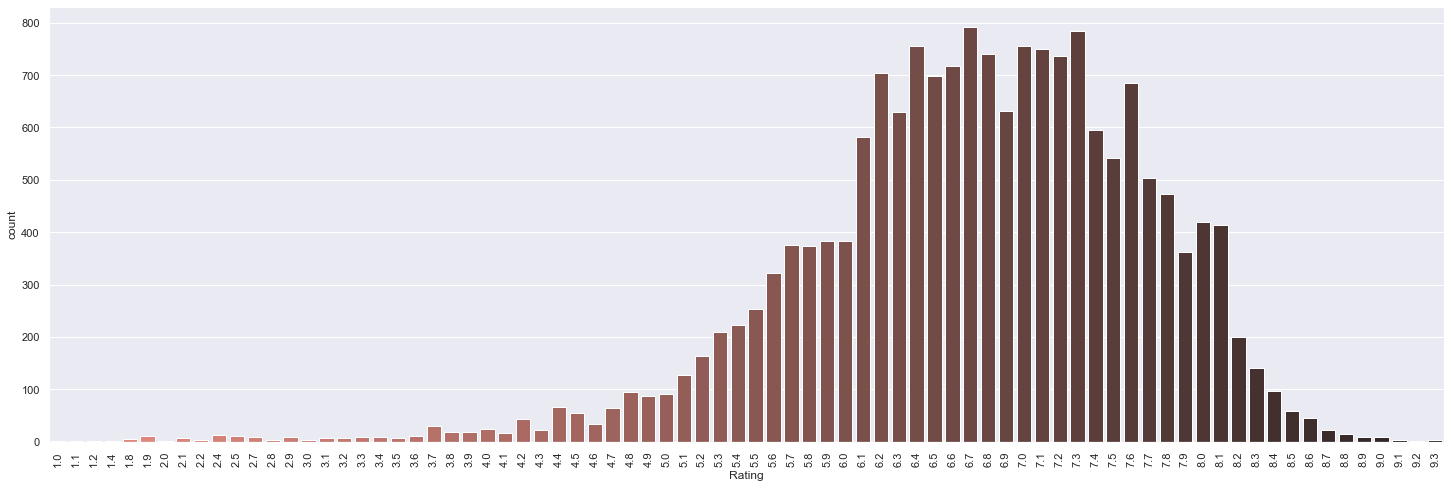

In [14]:
# countplot rating
plt.figure(figsize = (25,8))
ax = sns.countplot(x='Rating', data= data, palette='dark:salmon_r')
plt.xticks(rotation= 90)

Rating's skew: 0.9362600609348642
Rating's kurt: -0.707134955101866


C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-2.37195453, -2.02429227, -1.82195584, -1.67475005, -1.55685515,
         -1.45732576, -1.37044486, -1.29283054, -1.22230774, -1.15739046,
         -1.09701584, -1.04039577, -0.98692856, -0.93614359, -0.88766522,
         -0.8411883 , -0.79646114, -0.75327338, -0.71144706, -0.67082998,
         -0.63129074, -0.59271479, -0.55500149, -0.51806168, -0.48181576,
         -0.44619218, -0.41112616, -0.37655864, -0.34243544, -0.30870647,
         -0.27532518, -0.24224798, -0.20943379, -0.17684364, -0.14444028,
         -0.11218792, -0.08005187, -0.04799829, -0.01599397,  0.01599397,
          0.04799829,  0.08005187,  0.11218792,  0.14444028,  0.17684364,
          0.20943379,  0.24224798,  0.27532518,  0.30870647,  0.34243544,
          0.37655864,  0.41112616,  0.44619218,  0.48181576,  0.51806168,
          0.55500149,  0.59271479,  0.63129074,  0.67082998,  0.71144706,
          0.75327338,  0.79646114,  0.8411883 ,  0.88766522,  0.93614359,
          0.98692856,  1.04039577,  1.

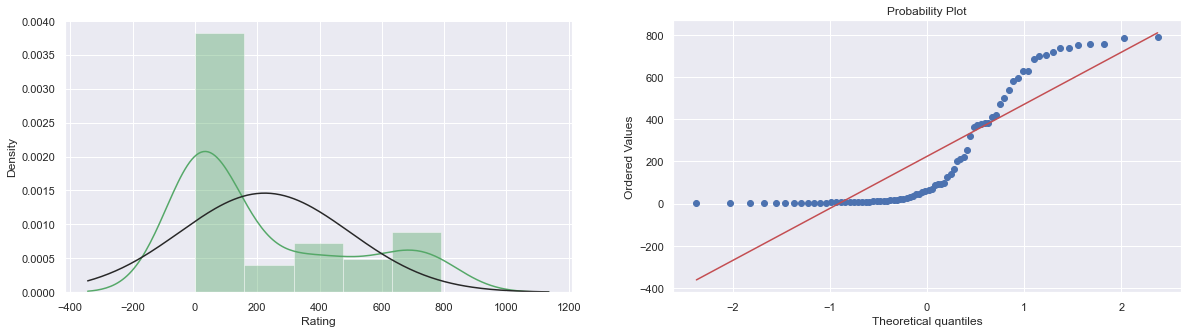

In [15]:
# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed
# Skewness is a measure of asymmetry of a distribution

# Kurtosis describes the peakedness of the distribution.
# High kurtosis in a data set is an indicator that data has heavy outliers.
# Low kurtosis in a data set is an indicator that data has lack of outliers.
# If kurtosis value + means pointy and — means flat.

rating_count = data.groupby('Rating')['Rating'].count()
print(f"Rating's skew: {rating_count.skew()}")
print(f"Rating's kurt: {rating_count.kurt()}")
f, ax = plt.subplots(1,2, figsize=(20,5))
rating_count = rating_count.to_frame()
sns.distplot(rating_count.Rating, fit=norm,color='g',ax=ax[0])
probplot(rating_count.Rating,plot=ax[1])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151]),
 [Text(0, 0, '45'),
  Text(1, 0, '46'),
  Text(2, 0, '63'),
  Text(3, 0, '64'),
  Text(4, 0, '66'),
  Text(5, 0, '67'),
  Text(6, 0, '68'),
  

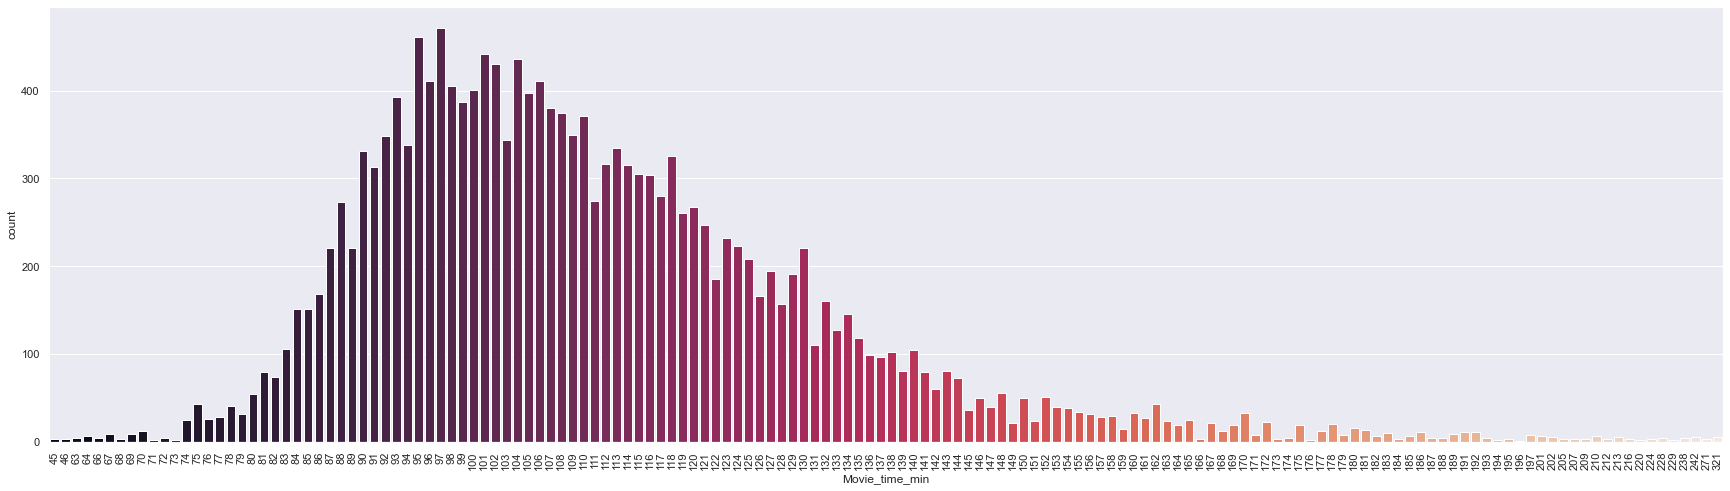

In [16]:
# countplot for Runtime
plt.figure(figsize = (30,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Movie_time_min', data= data, palette='rocket')
plt.xticks(rotation= 90)

Movie_time_min's skew: 1.0928078330565965
Movie_time_min's kurt: -0.24792844339791253


C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-2.60828957, -2.28890067, -2.10591774, -1.97438596, -1.87014095,
         -1.78297348, -1.7075655 , -1.64077866, -1.58059905, -1.52565375,
         -1.474963  , -1.42780197, -1.3836187 , -1.34198267, -1.30255131,
         -1.26504733, -1.22924293, -1.1949486 , -1.16200487, -1.1302762 ,
         -1.09964636, -1.07001489, -1.0412943 , -1.01340792, -0.98628816,
         -0.95987505, -0.93411519, -0.90896073, -0.88436868, -0.86030017,
         -0.83672   , -0.81359614, -0.79089936, -0.76860288, -0.74668211,
         -0.72511441, -0.70387886, -0.68295608, -0.6623281 , -0.64197819,
         -0.62189074, -0.60205115, -0.58244576, -0.56306175, -0.54388703,
         -0.52491024, -0.50612064, -0.48750805, -0.46906285, -0.45077588,
         -0.43263844, -0.41464222, -0.39677931, -0.37904213, -0.3614234 ,
         -0.34391617, -0.32651373, -0.30920962, -0.29199761, -0.27487168,
         -0.257826  , -0.2408549 , -0.22395291, -0.20711465, -0.19033491,
         -0.1736086 , -0.15693072, -0.

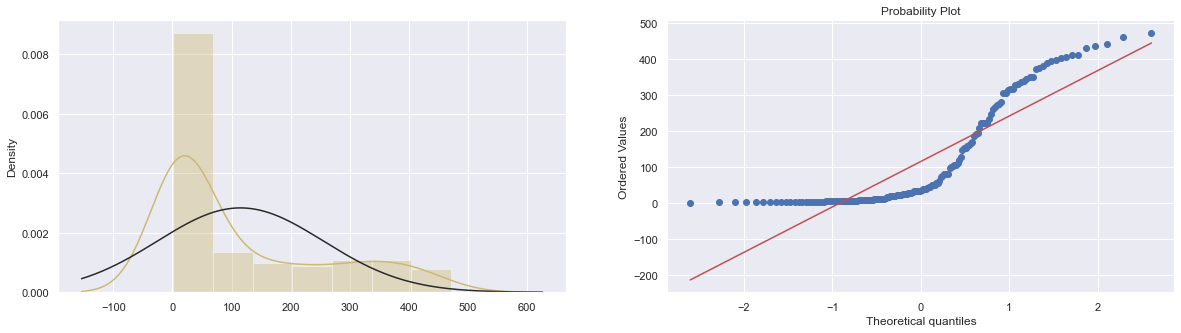

In [17]:
Movie_time_min_count = data.groupby('Movie_time_min')['Movie_time_min'].count()
print(f"Movie_time_min's skew: {Movie_time_min_count.skew()}")
print(f"Movie_time_min's kurt: {Movie_time_min_count.kurt()}")
f, ax = plt.subplots(1,2, figsize=(20,5))
Movie_time_min_count = Movie_time_min_count.to_frame()
sns.distplot(Movie_time_min_count, fit=norm,color='y',ax=ax[0])
probplot(Movie_time_min_count.Movie_time_min,plot=ax[1])

(array([1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

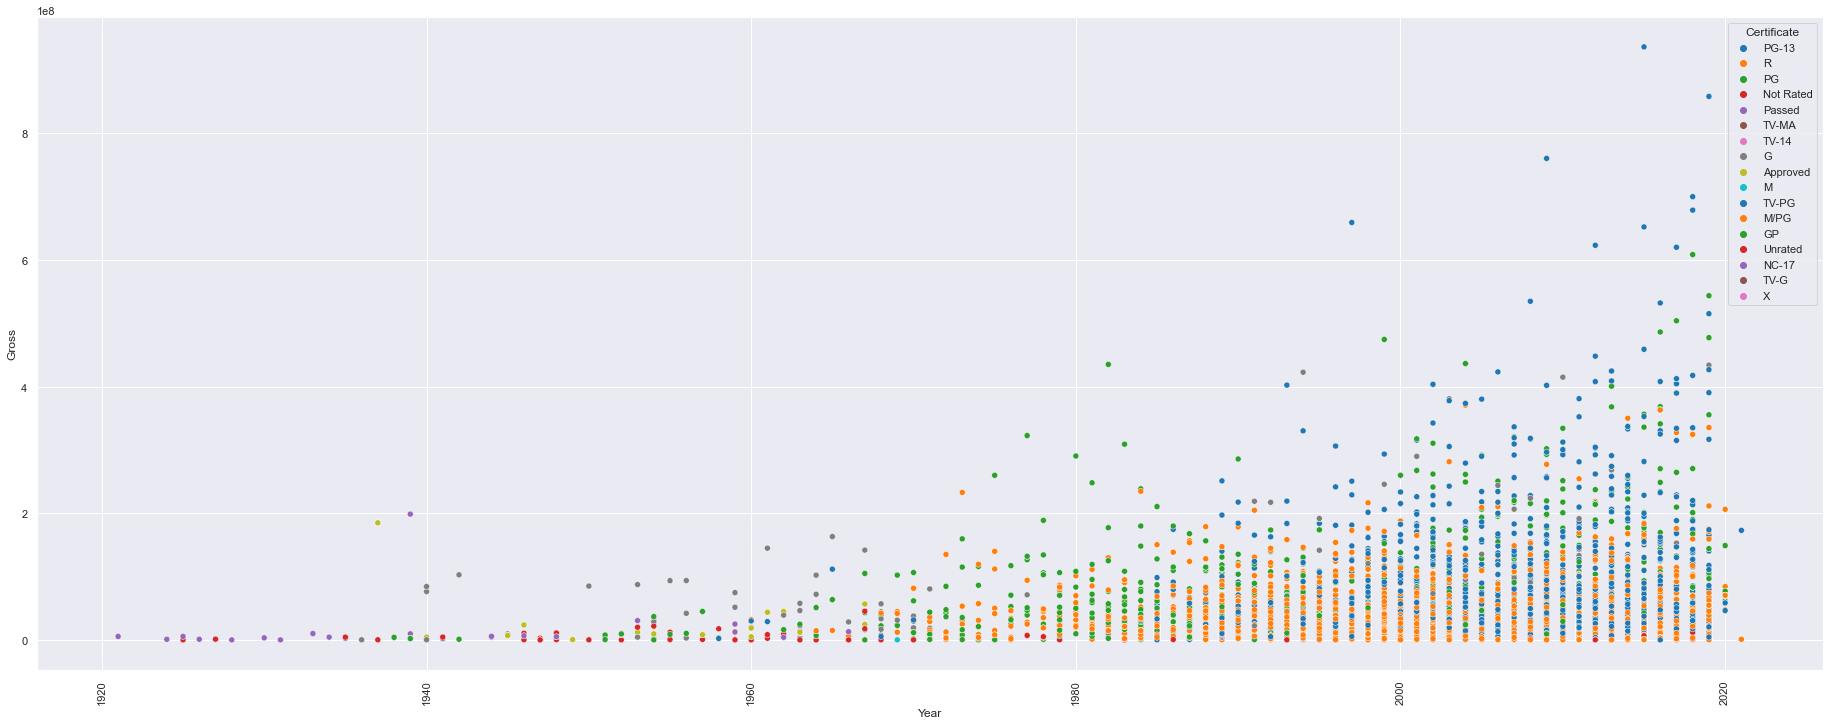

In [18]:

plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Year', y='Gross', data= data,hue='Certificate', palette='tab10')
plt.xticks(rotation= 90)

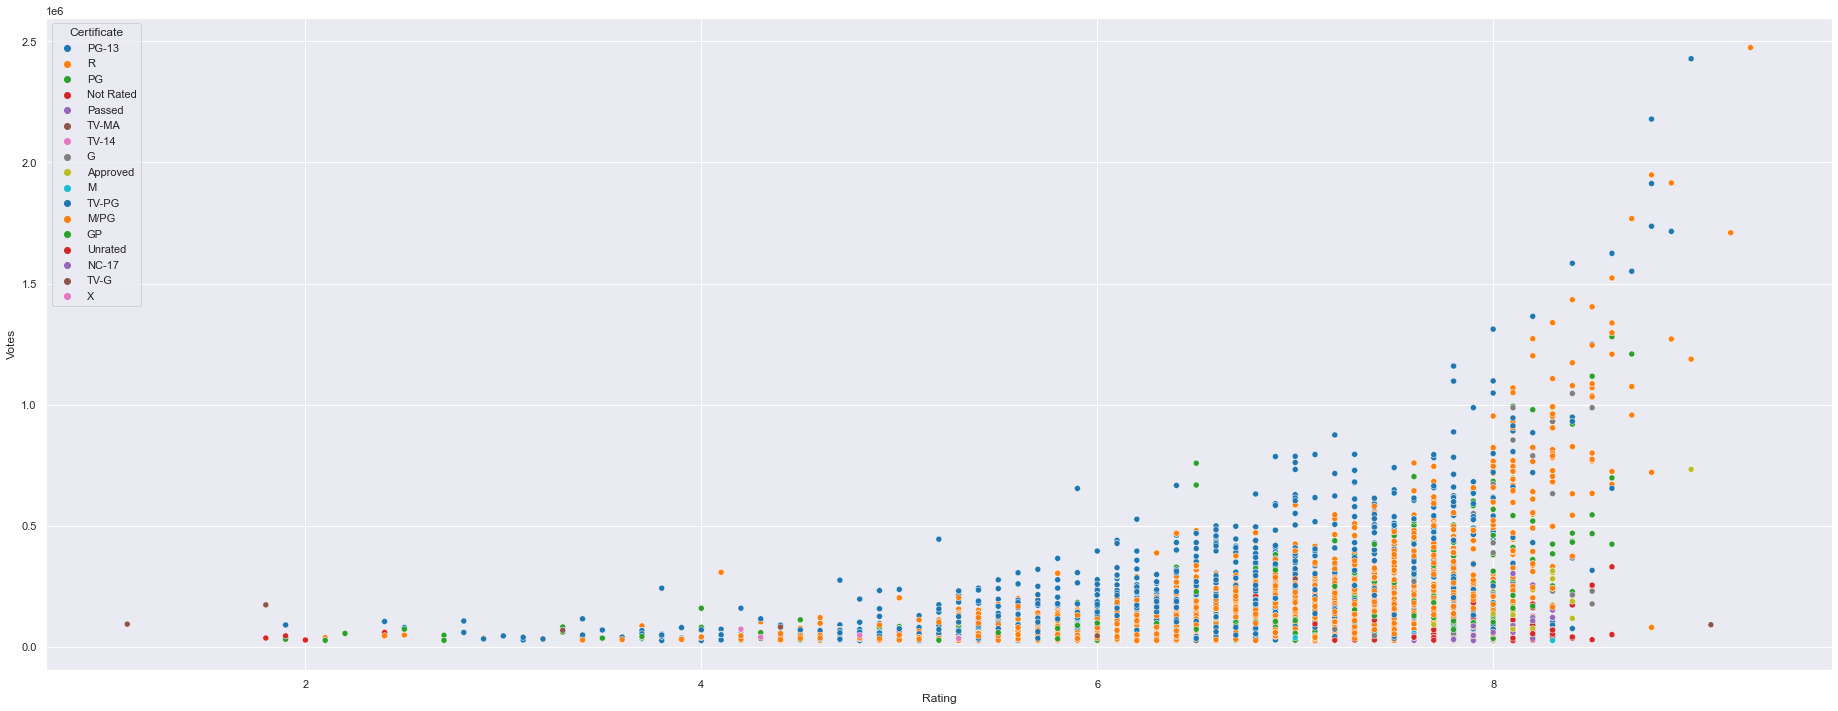

In [19]:
plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Rating', y='Votes', data= data,hue='Certificate', palette='tab10')

<AxesSubplot:title={'center':'Mean Rating Per Year'}, xlabel='Year'>

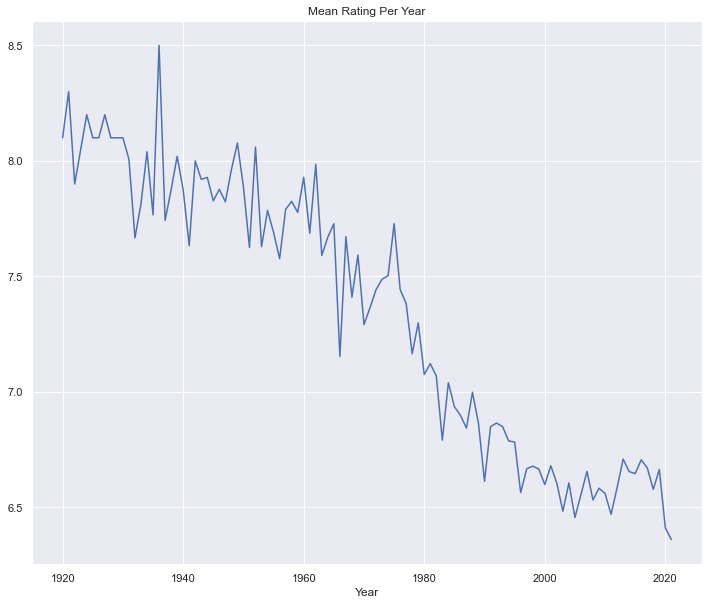

In [20]:
# mean rating for each year
mean_rating_year = data.groupby(by=['Year'])['Rating'].mean()
mean_rating_year.plot(title='Mean Rating Per Year')

<AxesSubplot:title={'center':'Mean Movie Time Per Year'}, xlabel='Year'>

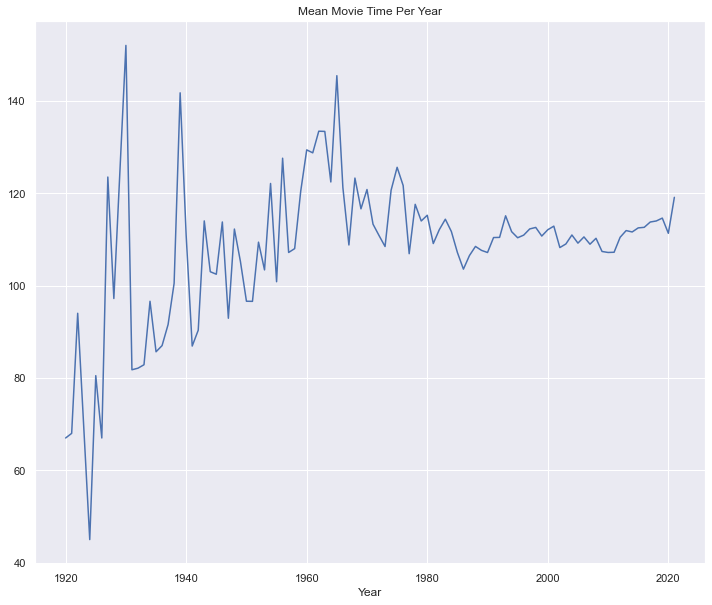

In [21]:
mean_time_year = data.groupby(by=['Year'])['Movie_time_min'].mean()
mean_time_year.plot(kind='line',title='Mean Movie Time Per Year')

In [40]:
genre_description = data[l].describe().T
genre_description.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
Drama,17483.0,0.520906,0.499577,0.0,0.0,1.0,1.0,1.0
Comedy,17483.0,0.362695,0.480792,0.0,0.0,0.0,1.0,1.0
Action,17483.0,0.340102,0.473757,0.0,0.0,0.0,1.0,1.0
Adventure,17483.0,0.280844,0.449424,0.0,0.0,0.0,1.0,1.0
Crime,17483.0,0.234170,0.423491,0.0,0.0,0.0,0.0,1.0
Thriller,17483.0,0.151118,0.358174,0.0,0.0,0.0,0.0,1.0
Romance,17483.0,0.133844,0.340495,0.0,0.0,0.0,0.0,1.0
Mystery,17483.0,0.117943,0.322550,0.0,0.0,0.0,0.0,1.0
Horror,17483.0,0.112624,0.316141,0.0,0.0,0.0,0.0,1.0
Fantasy,17483.0,0.103987,0.305252,0.0,0.0,0.0,0.0,1.0


In [41]:
# select the most 6 genres
drama = data[data['Drama'] == 1]
comedy = data[data['Comedy'] == 1]
action = data[data['Action'] == 1]
adventure = data[data['Adventure'] == 1]
crime = data[data['Crime'] == 1]
thriller = data[data['Thriller'] == 1]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

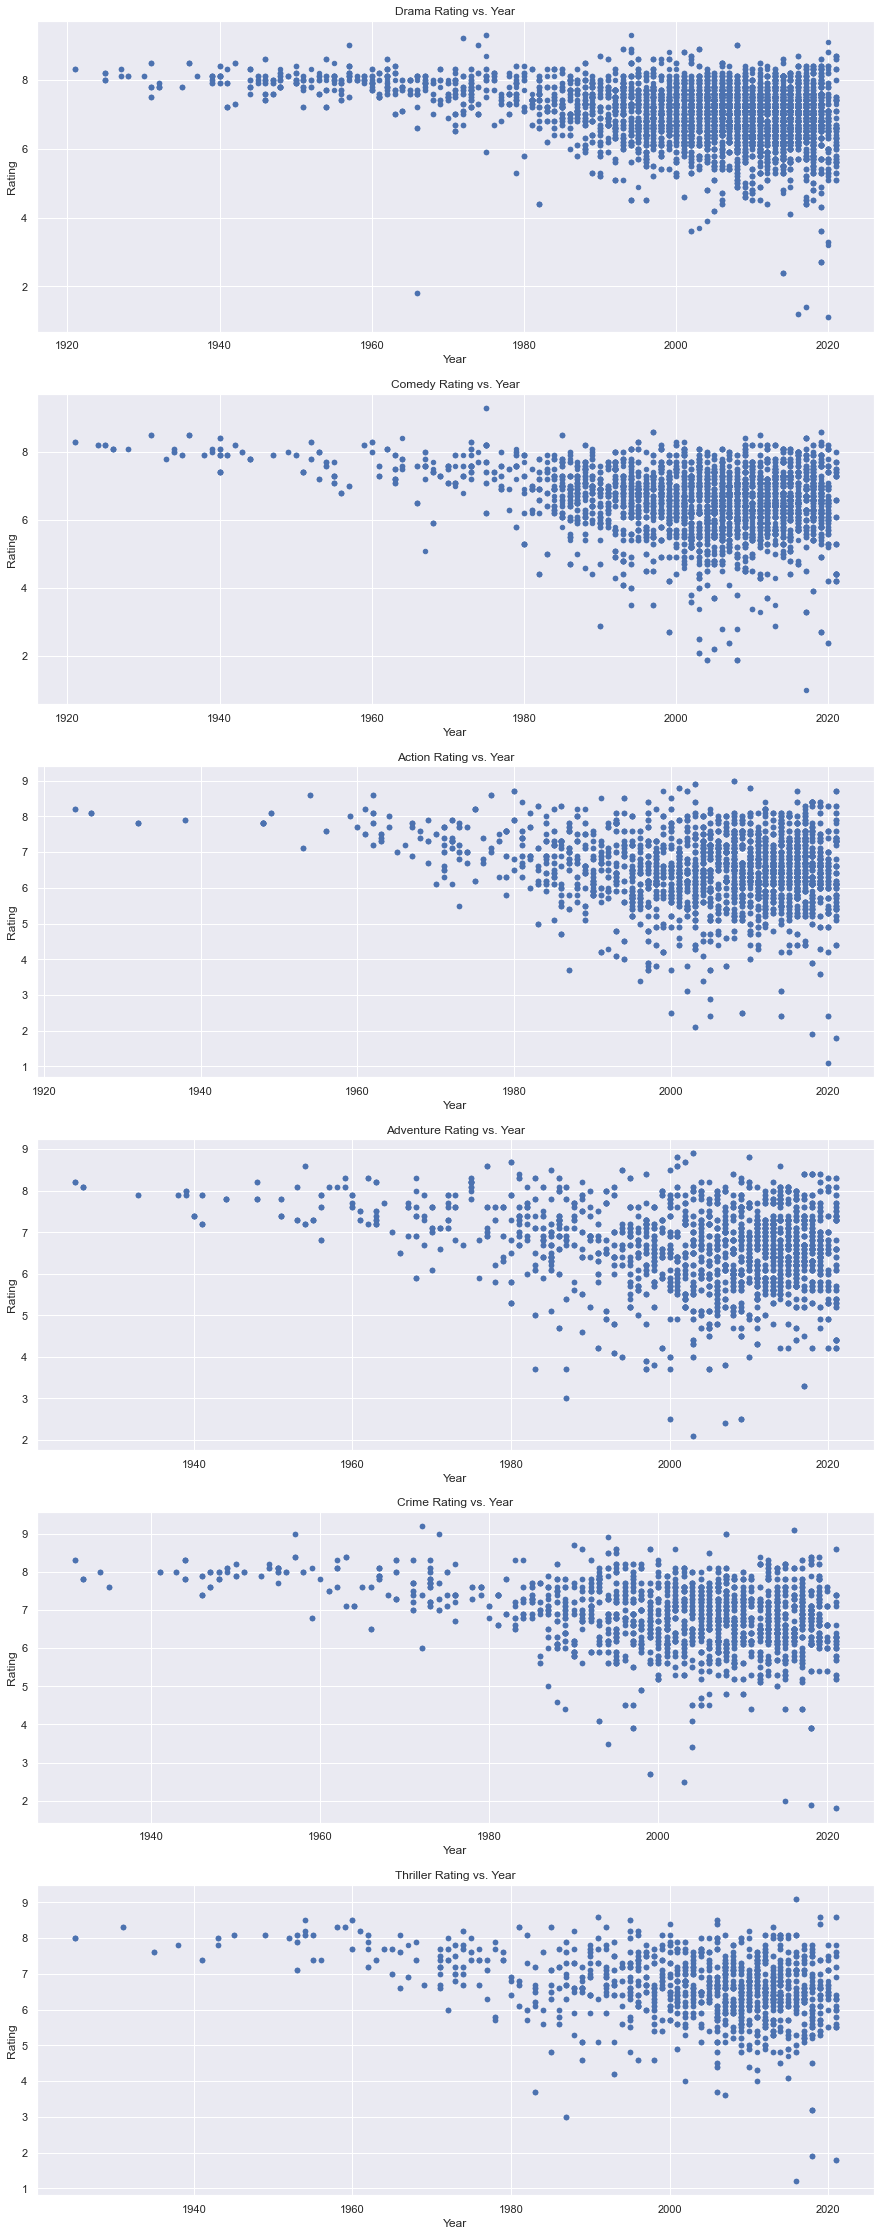

In [42]:
top_6 = [drama,comedy,action,adventure,crime,thriller]

figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Rating vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Rating',ax=axes[i],title=Title[i])



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

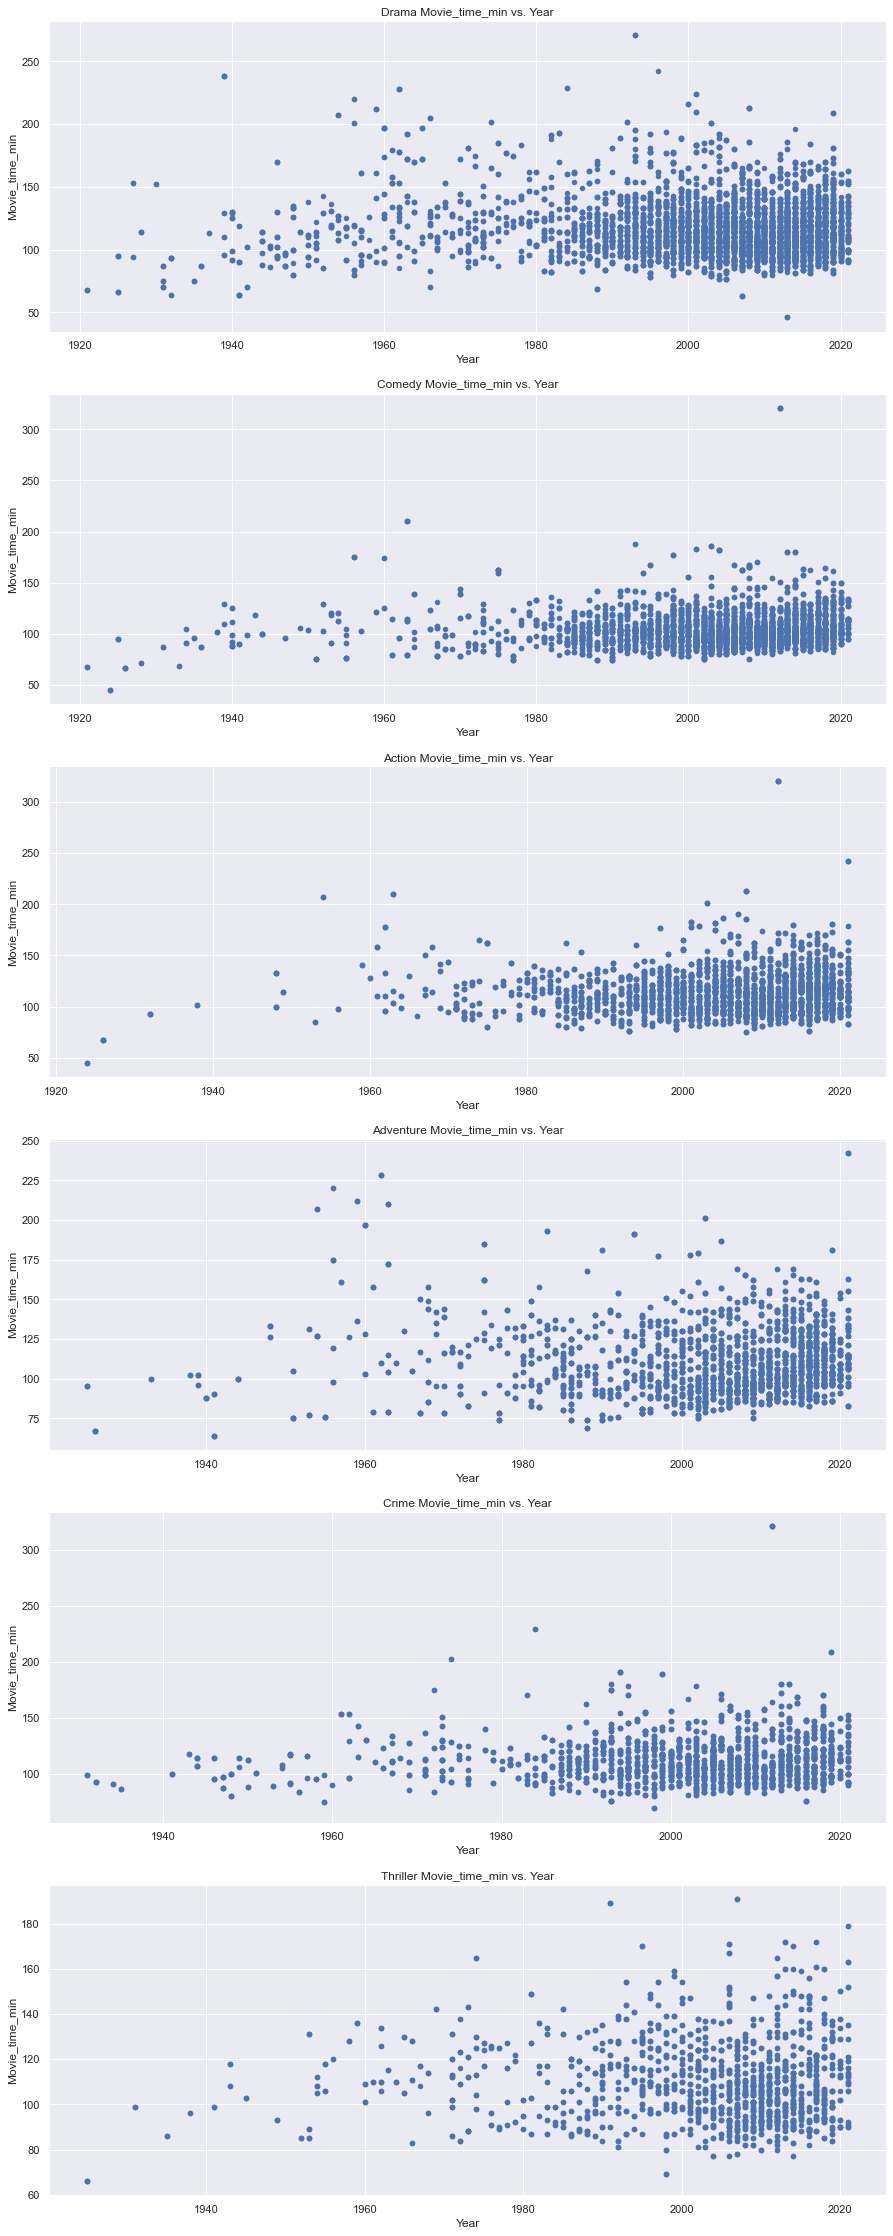

In [25]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Movie_time_min vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Movie_time_min',ax=axes[i],title=Title[i])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

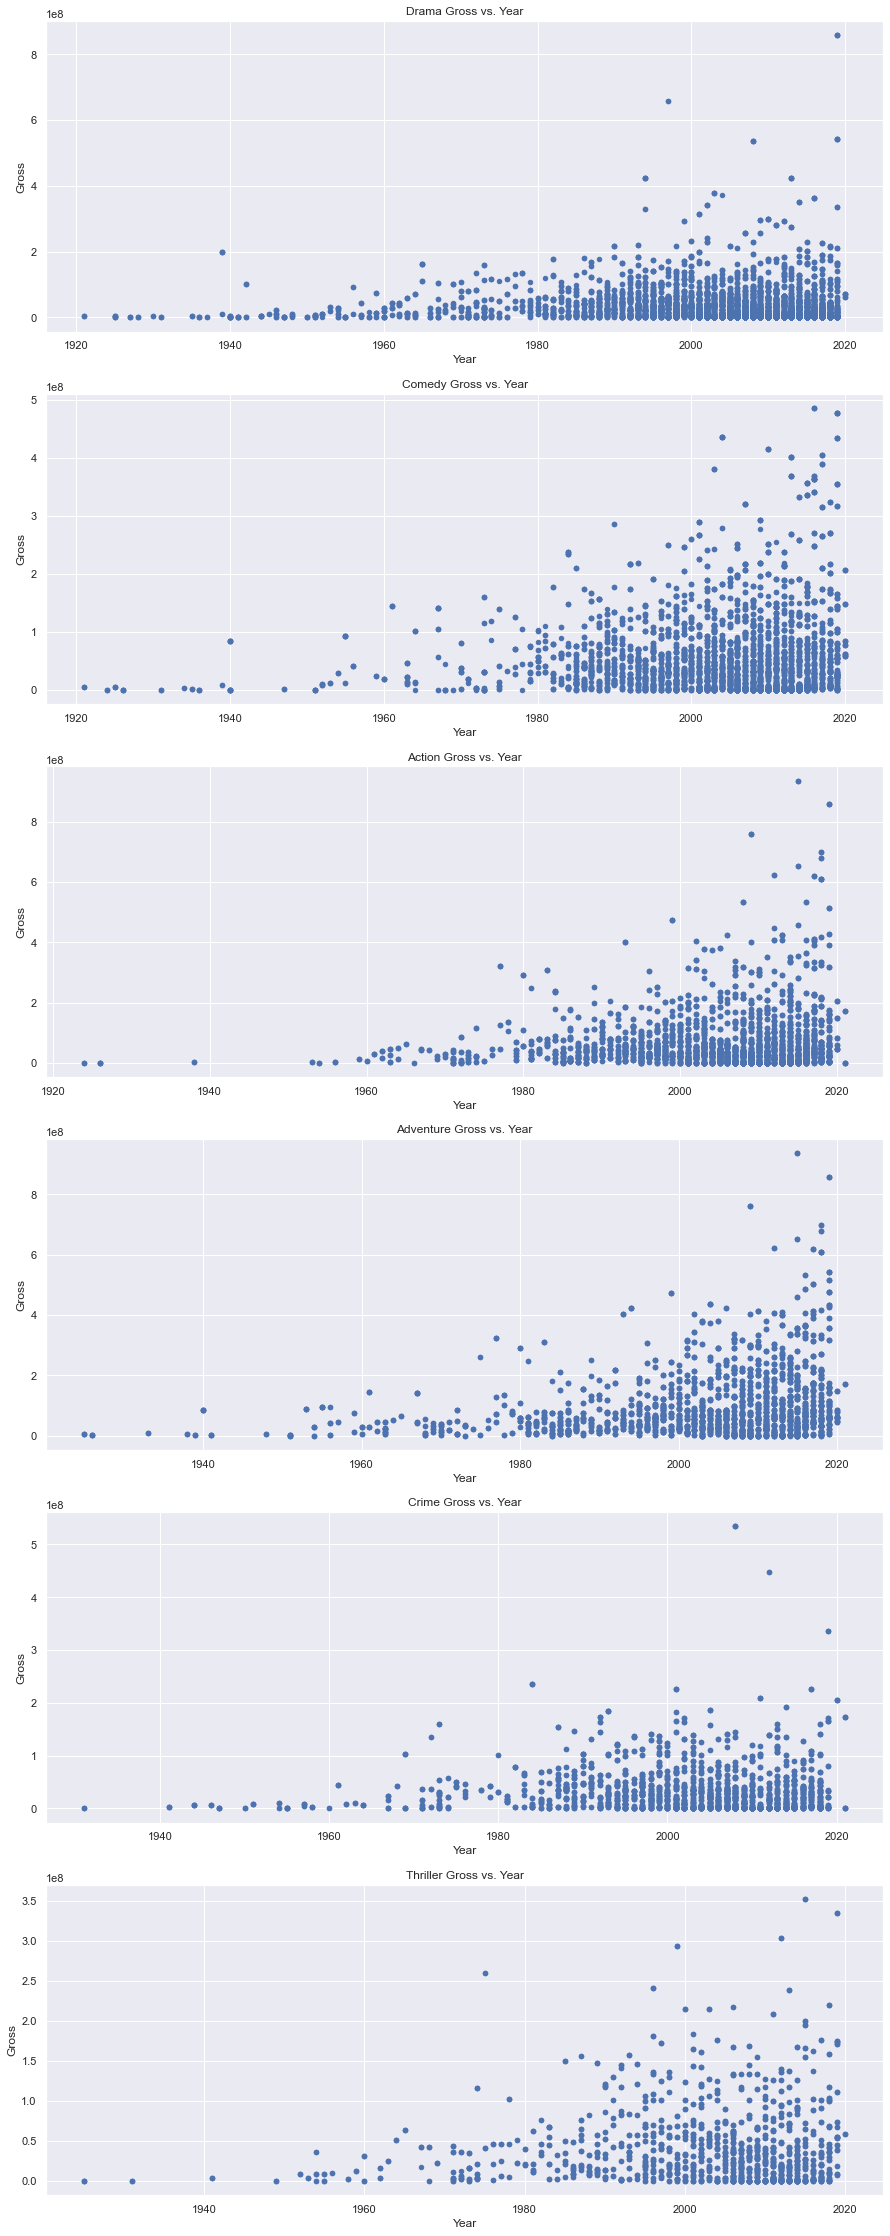

In [26]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Gross vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Gross',ax=axes[i],title=Title[i])

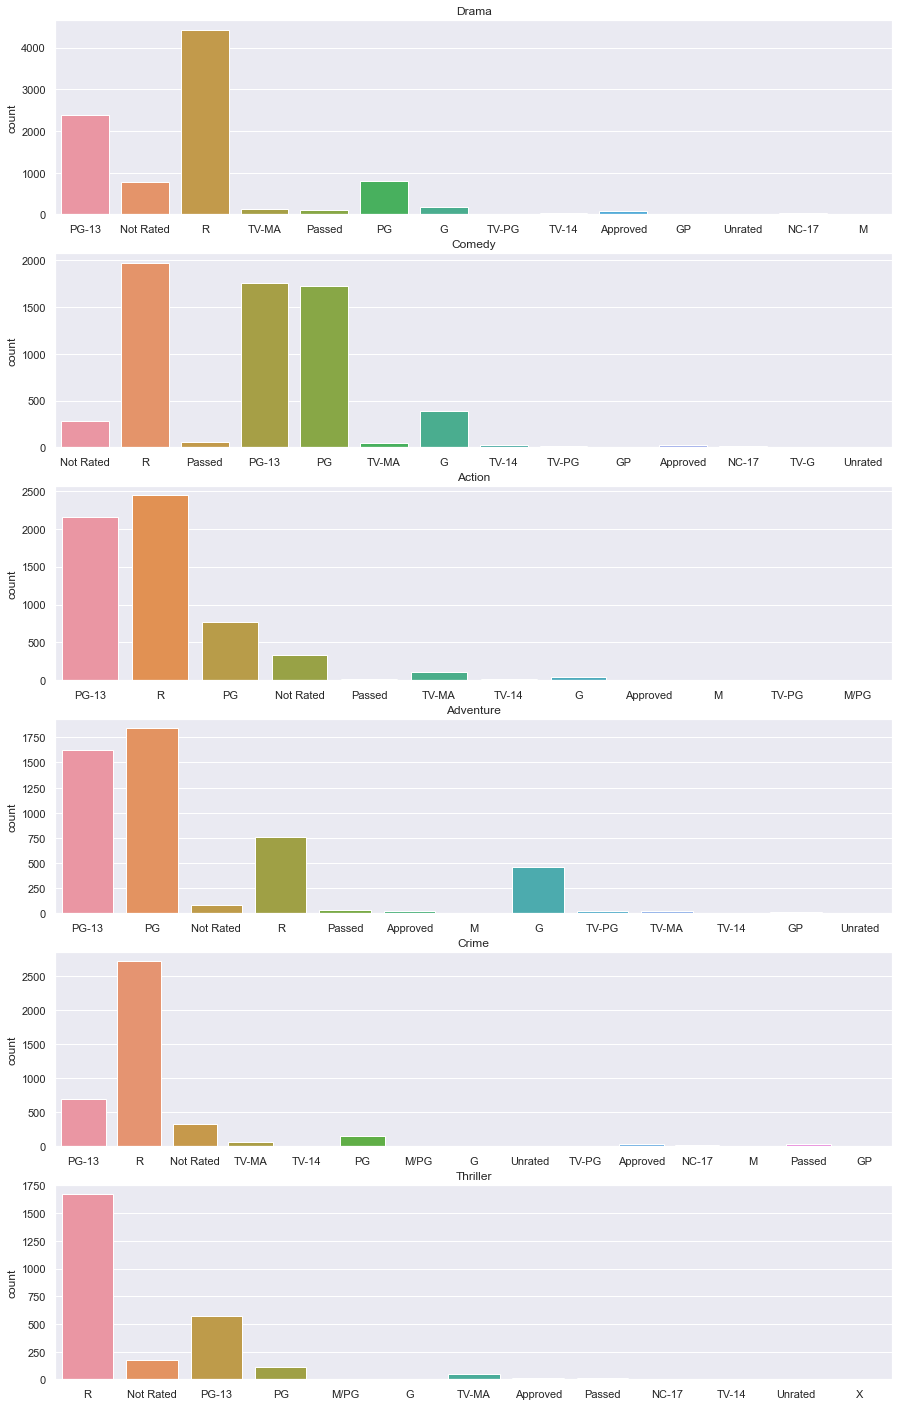

In [27]:
figure, axes = plt.subplots(6, 1, figsize=(15,25))

title = ' Certificate'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    ax = sns.countplot(x='Certificate',data=top_6[i], ax = axes[i])
    ax.set(title=pre[i],xlabel='')

In [43]:
num_vars = data.columns[data.dtypes != 'object']
obj_vars = data.columns[data.dtypes == 'object']

pd.DataFrame(num_vars, columns=['num vars']).T
continuous_vars = ['Rank','Year','Rating','Metascore','Votes','Gross','Movie_time_min']

In [44]:
pd.DataFrame(obj_vars, columns=['obj vars']).T
nominal_vars = ['Title', 'Certificate','Runtime','Genre','URL','Intro']

In [45]:
cnt_missing = data.isnull().sum().sort_values(ascending=False)
cnt_percent = cnt_missing / data.shape[0]

missing_table = pd.DataFrame([cnt_missing, cnt_percent],index=['missing count','missing percent']).T
missing_table = missing_table[missing_table['missing count'] > 0]
missing_table

,missing count,missing percent
Metascore,9962.0,0.569811
Gross,2249.0,0.128639
Certificate,115.0,0.006578


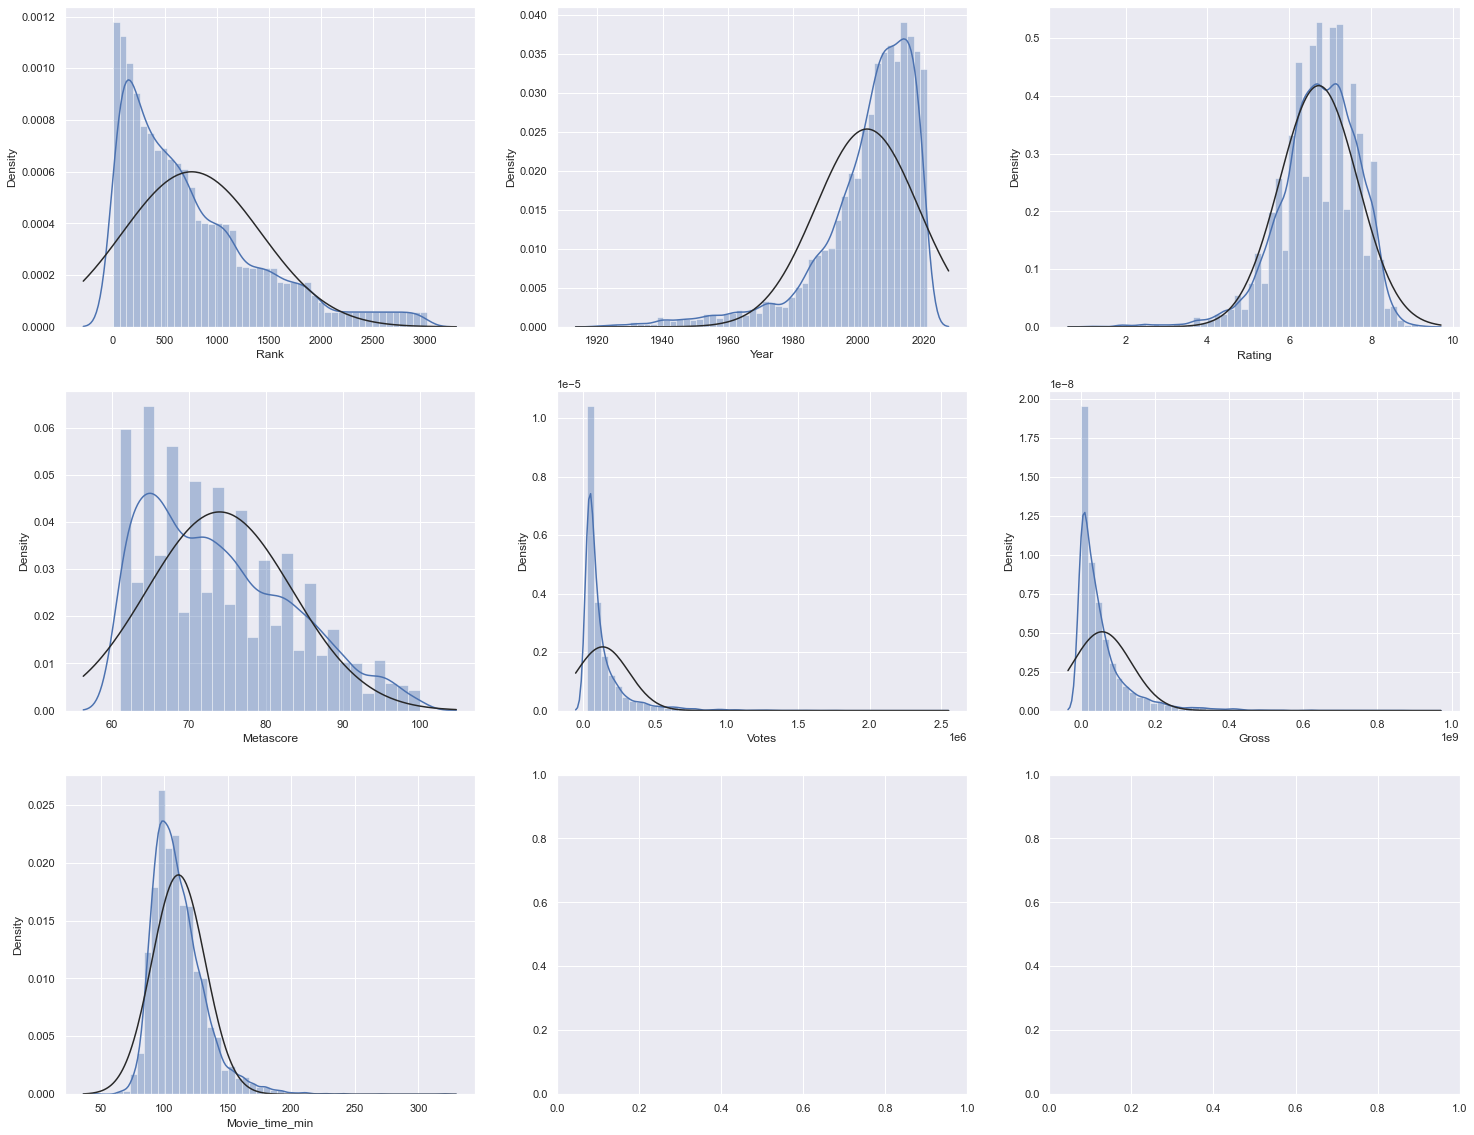

In [46]:
f, ax = plt.subplots(3, 3, figsize=(25, 20))
for i, c in enumerate(continuous_vars):
    sns.distplot(data[c], fit=norm, ax=ax[i//3, i%3])

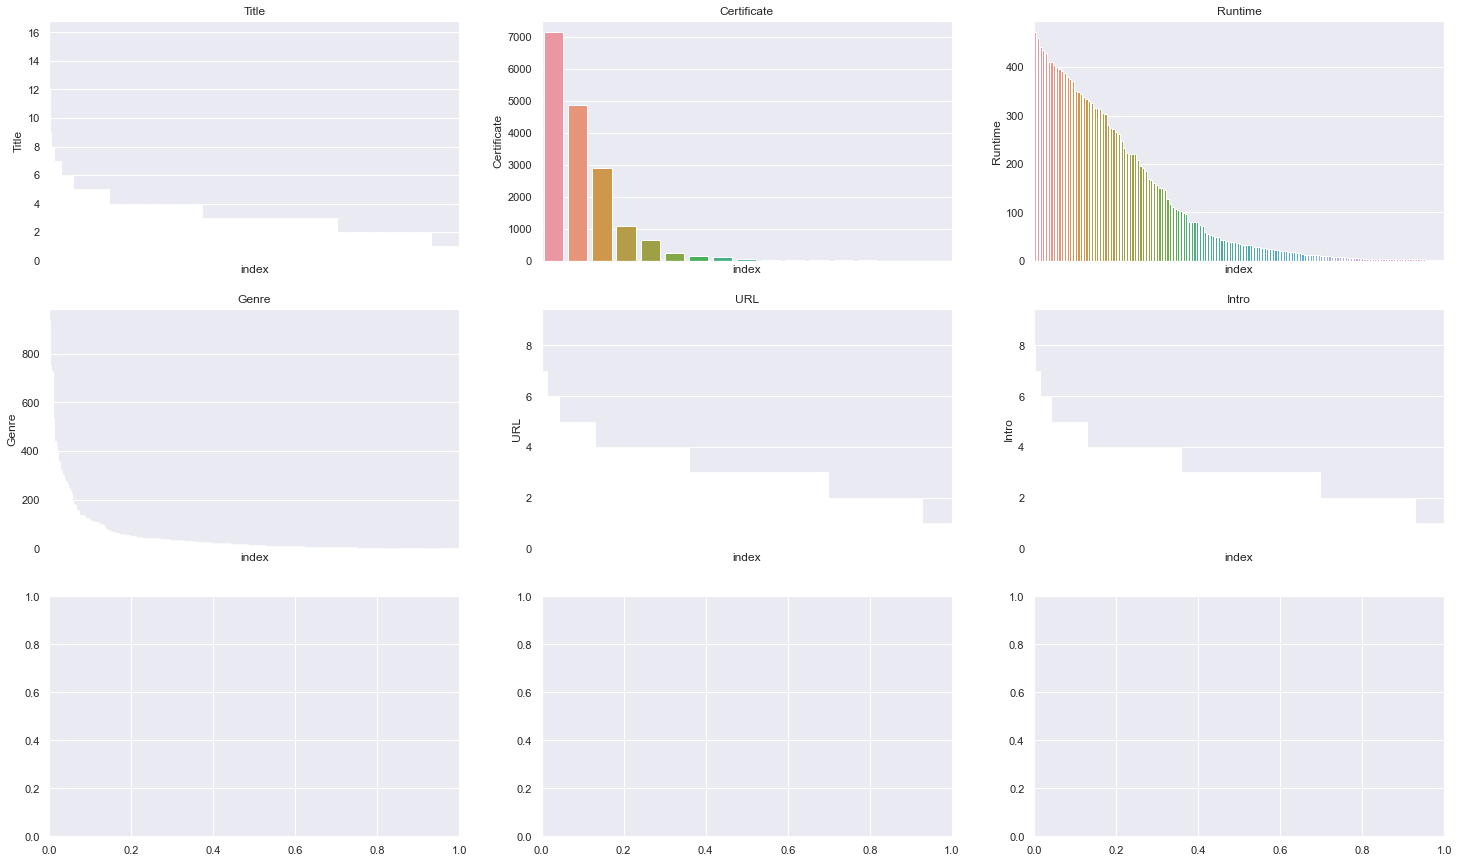

In [32]:
f, ax = plt.subplots(3, 3, figsize=(25, 15))
for i, c in enumerate(nominal_vars):
    g = sns.barplot(data=pd.DataFrame(data[c].value_counts()).reset_index(), x='index', y=c, ax=ax[i//3, i%3])
    g.set(xticks=[])
    g.set(title=c)

<AxesSubplot:>

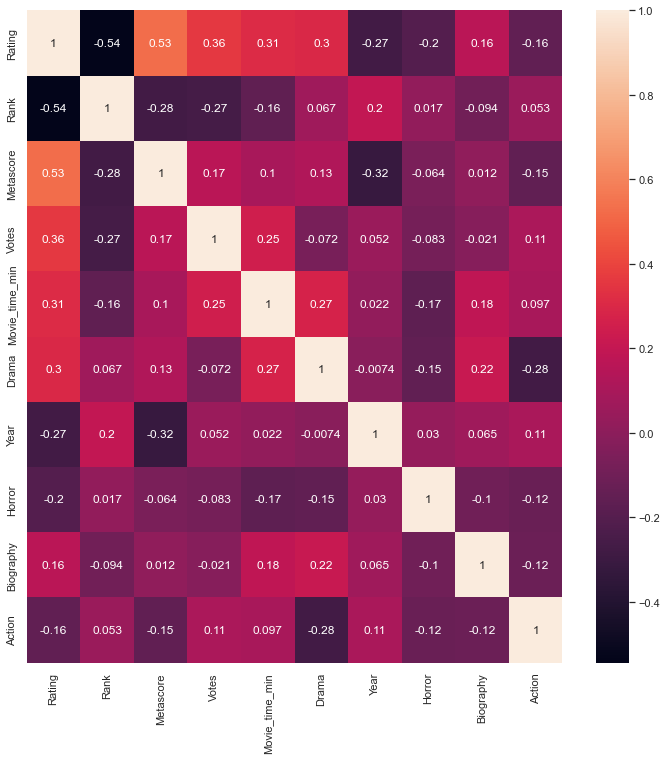

In [47]:
f, ax = plt.subplots(figsize=(12, 12))
highcorr_vars = (abs(data.corr().Rating).sort_values(ascending=False)[:10]).index
sns.heatmap(data[highcorr_vars].corr(), annot=True)

In [48]:
def hypo_test(x, y, cat=False):
    f, ax = plt.subplots(1, 4, figsize=(25, 5))
    if cat:
        sns.boxplot(x=data[x], y=data[y], ax=ax[0])
    else:
        sns.scatterplot(x=data[x], y=data[y], ax=ax[0])
        sns.regplot(x=data[x], y=data[y], ax=ax[0])
    sns.residplot(x=data[x], y=data[y], ax=ax[1])
    sns.distplot(data[x], fit=norm, ax=ax[2])
    probplot(data[x], plot=ax[3])
    plt.show()

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


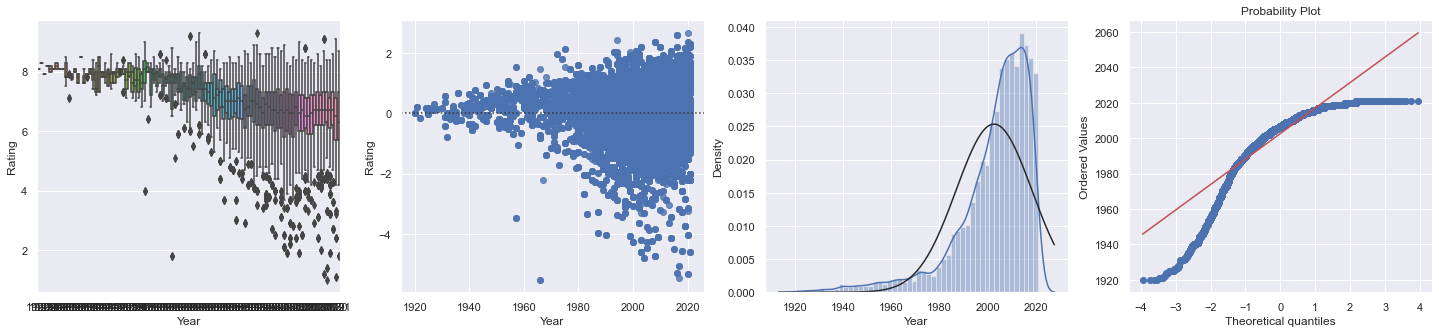

In [35]:
hypo_test('Year','Rating',True)

In [36]:
highcorr_vars

Index(['Rating', 'Rank', 'Metascore', 'Votes', 'Movie_time_min', 'Drama',
       'Year', 'Horror', 'Biography', 'Action'],
      dtype='object')

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


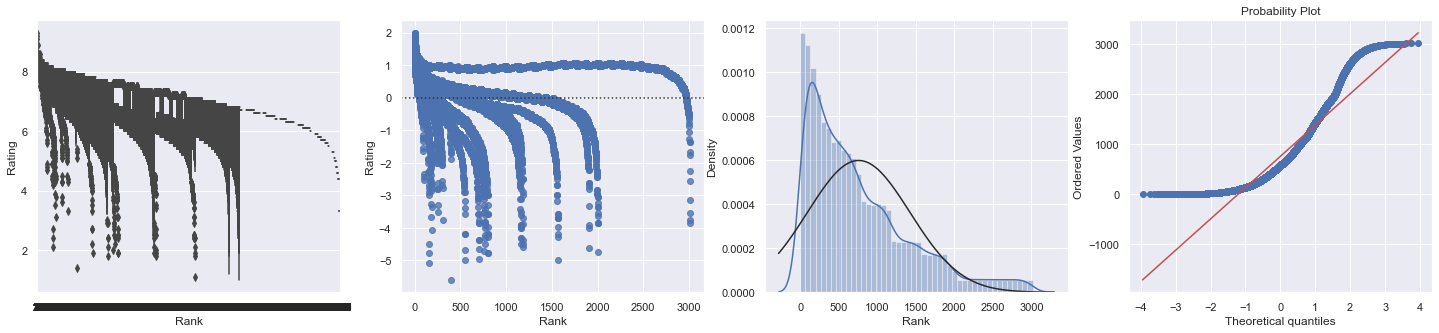

In [37]:
hypo_test('Rank','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


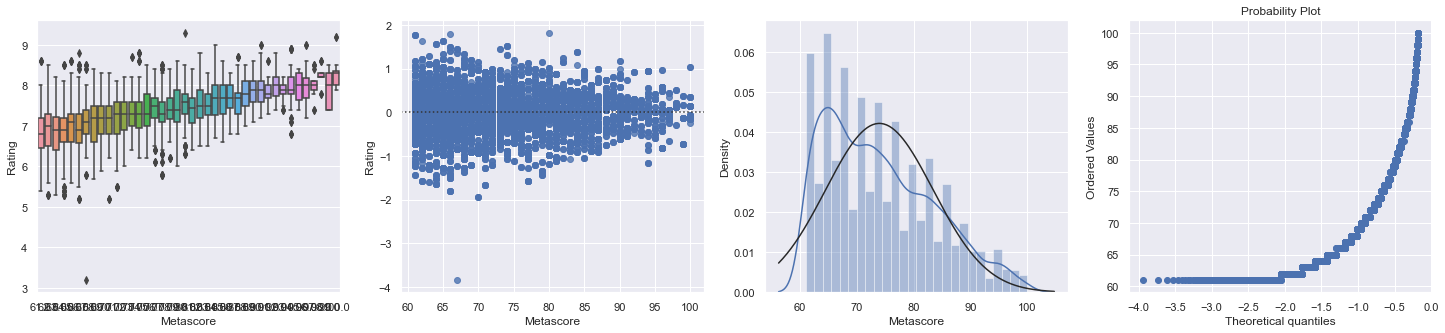

In [38]:
hypo_test('Metascore','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


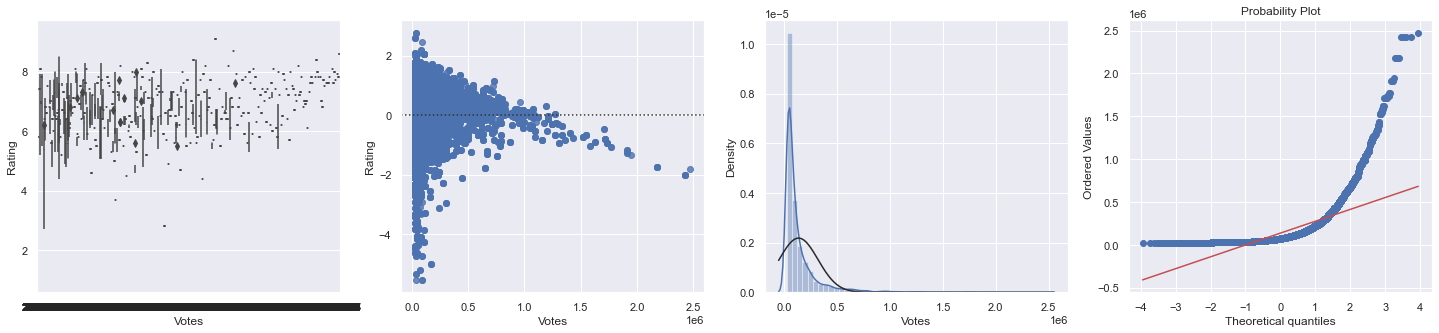

In [39]:
hypo_test('Votes','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


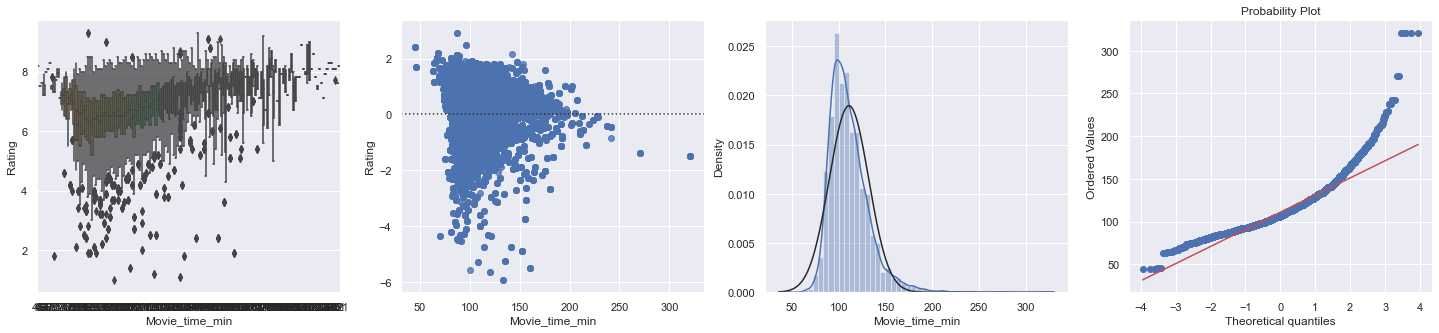

In [40]:
hypo_test('Movie_time_min','Rating',True)

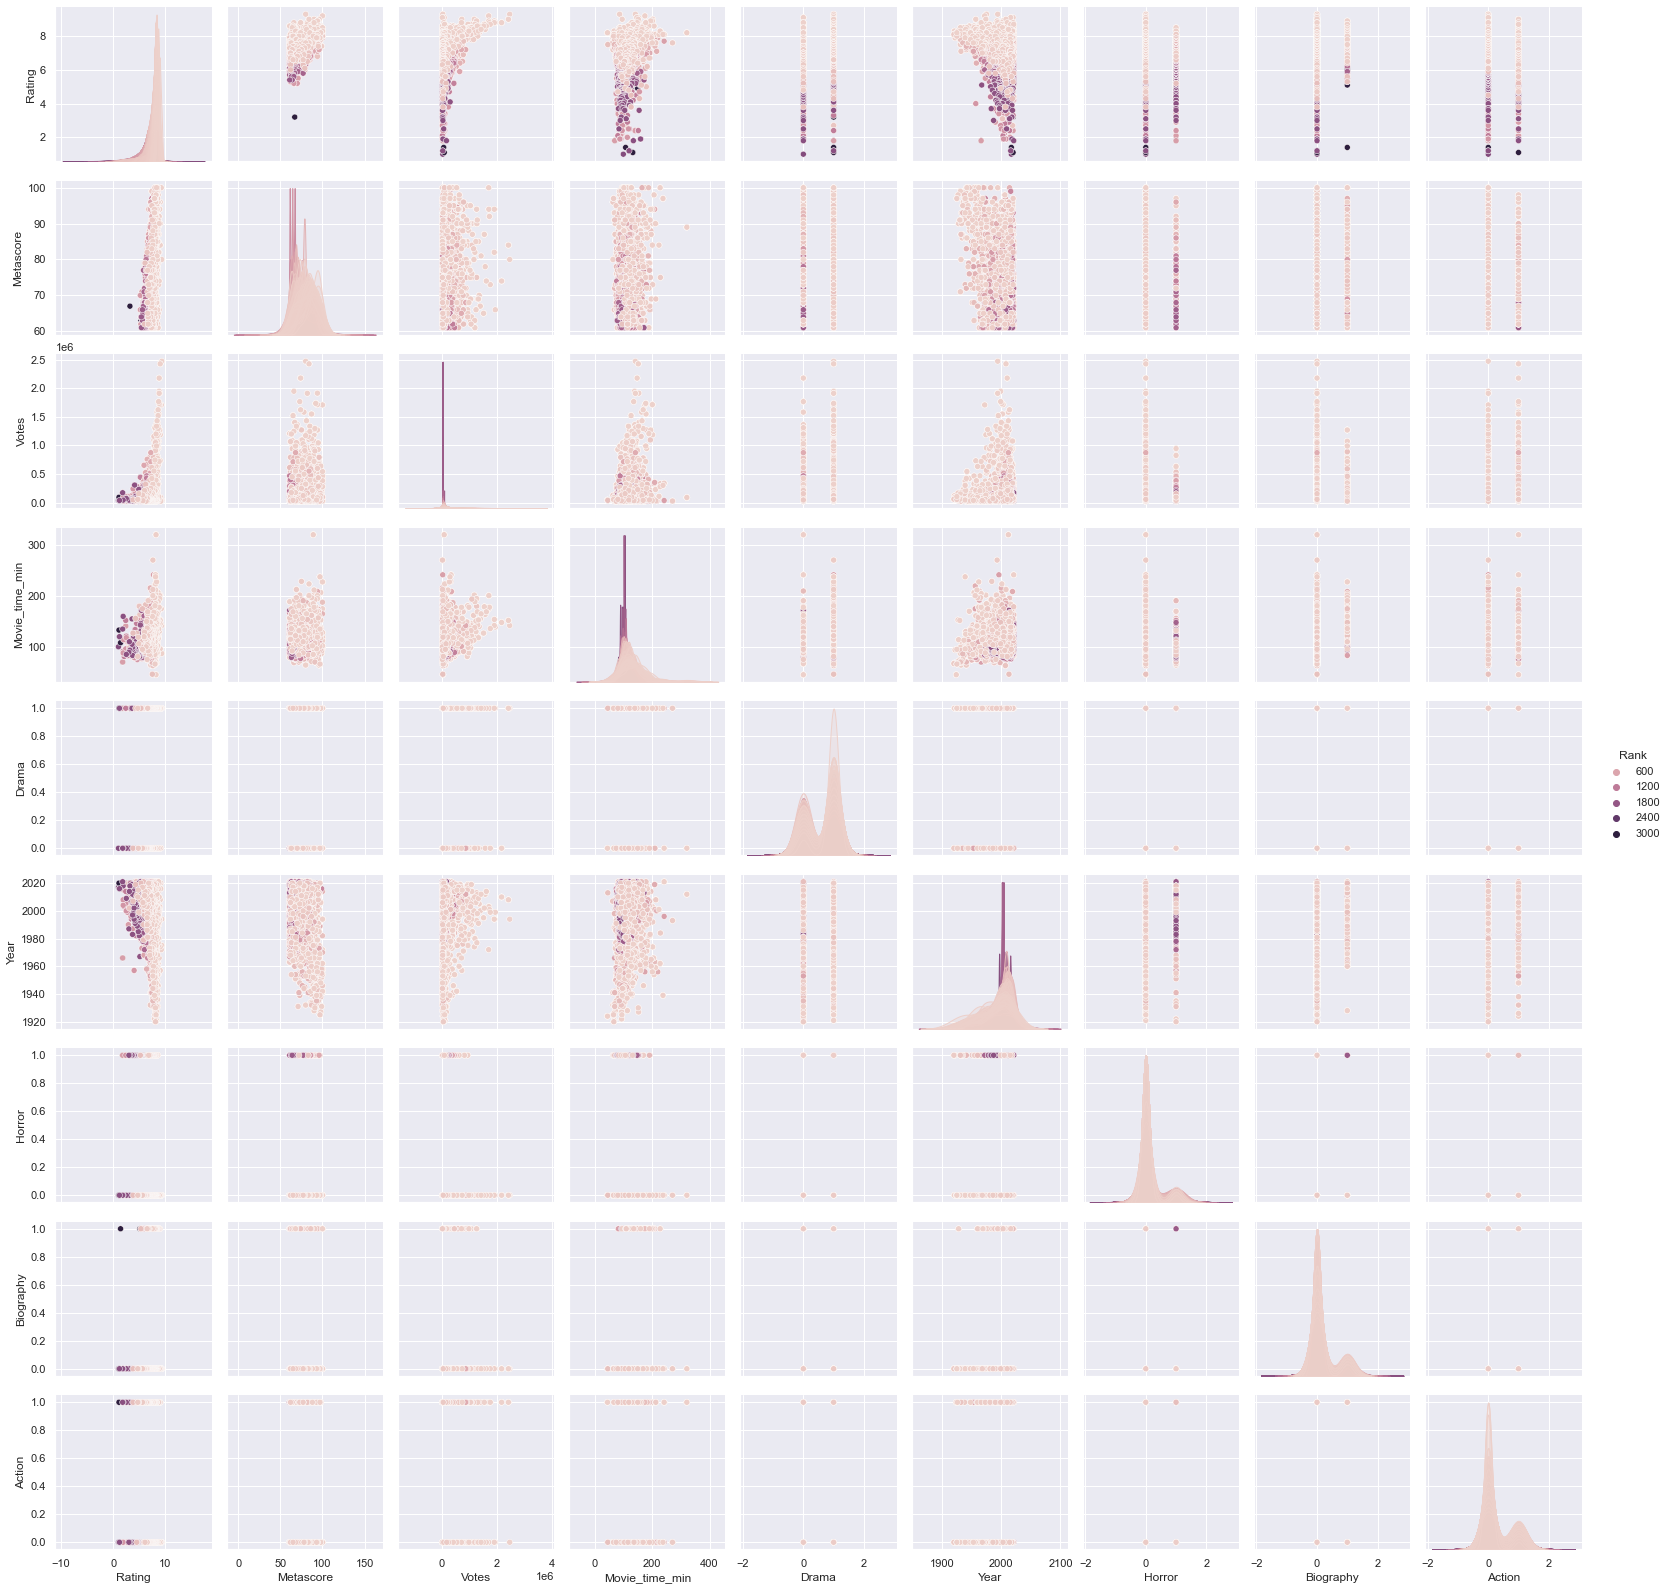

In [45]:
sns.pairplot(data[highcorr_vars], hue ='Rank')

In [49]:
y = data.Rank.values
y

array([  1,   2,   3, ...,  98,  99, 100], dtype=int64)

In [50]:
all_data = data
all_data.drop(['Rank','URL','Intro','Runtime'，'Genre'], axis = 1, inplace= True)

In [51]:
all_data['Title'] = data['Title'].apply(lambda x: int(len(x)))
all_data

,Title,Year,Certificate,Genre,Rating,Metascore,Votes,Gross,Movie_time_min,Biography,Music,Comedy,Animation,Film-Noir,Mystery,Sport,History,Adventure,Crime,War,Thriller,Drama,Western,Musical,Sci-Fi,Romance,Action,Fantasy,Family,Horror
0,15,2008,PG-13,"Action, Crime, Drama",9.0,84.0,2428474,534858444.0,152,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,45,2003,PG-13,"Action, Adventure, Drama",8.9,94.0,1715249,377845905.0,201,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,9,2010,PG-13,"Action, Adventure, Sci-Fi",8.8,74.0,2179206,292576195.0,148,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,49,2001,PG-13,"Action, Adventure, Drama",8.8,92.0,1736538,315544750.0,178,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,15,2016,NaN,"Action, Drama, War",8.7,NaN,106888,NaN,135,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17478,8,2006,PG-13,"Action, Comedy, Crime",5.7,NaN,34959,NaN,93,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
17479,14,2017,PG-13,"Action, Adventure, Fantasy",5.6,NaN,133686,50701325.0,95,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
17480,14,1999,PG-13,"Action, Comedy, Sci-Fi",4.9,NaN,156698,113805681.0,106,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
17481,16,2015,TV-14,"Action, Adventure, Comedy",4.8,NaN,46824,NaN,119,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [52]:
certificates = all_data['Certificate'].unique()
certificates = certificates.tolist()
tmp_num = [x for x in range(18)]
all_data['Certificate'] = all_data['Certificate'].apply(lambda x: int(tmp_nuum[certificates.index(x)]))

['PG-13',
 nan,
 'R',
 'PG',
 'Not Rated',
 'Passed',
 'TV-MA',
 'TV-14',
 'G',
 'Approved',
 'M',
 'TV-PG',
 'M/PG',
 'GP',
 'Unrated',
 'NC-17',
 'TV-G',
 'X']

In [55]:
metascore_mean = all_data['Metascore'].mean()
all_data['Metascore'].fillna(value = metascore_mean, inplace= True)
gross_mean = all_data['Gross'].mean()
all_data['Gross'].fillna(value= gross_mean, inplace= True)

In [57]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           17483 non-null  int64  
 1   Year            17483 non-null  int64  
 2   Certificate     17483 non-null  int64  
 3   Rating          17483 non-null  float64
 4   Metascore       17483 non-null  float64
 5   Votes           17483 non-null  int64  
 6   Gross           17483 non-null  float64
 7   Movie_time_min  17483 non-null  int64  
 8   Biography       17483 non-null  int64  
 9   Music           17483 non-null  int64  
 10  Comedy          17483 non-null  int64  
 11  Animation       17483 non-null  int64  
 12  Film-Noir       17483 non-null  int64  
 13  Mystery         17483 non-null  int64  
 14  Sport           17483 non-null  int64  
 15  History         17483 non-null  int64  
 16  Adventure       17483 non-null  int64  
 17  Crime           17483 non-null 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size = 0.25, random_state = 42)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13112, 29), (4371, 29), (13112,), (4371,))

In [61]:
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error',
                   cv=5, verbose=0, n_jobs=-1))

In [62]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso())
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(max_iter=5000))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])

model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR())
])

grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__l1_ratio': 0.001 * np.arange(1, 10)
}
grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}
grid_param_svr = {
    'model__C': [0.001, 0.1, 1, 10, 20],
    'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
    'model__epsilon': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]
}

best_params = {}

In [63]:
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params['Lasso'] = search_lasso.best_params_

In [64]:
best_params

{'Lasso': {'model__alpha': 0.0099}}

In [114]:
#search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
#                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
#best_params['ElasticNet'] = search_elasticNet.best_params_

In [ ]:
#search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
#                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
#best_params['KernelRidge'] = search_krr.best_params_

In [65]:
#search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
#                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
#best_params['SVR'] = search_svr.best_params_

KeyboardInterrupt: 

In [66]:
def objective_xgb(trial, X, y):
    param = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
        'n_jobs': -1
    }
    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                 eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
                 early_stopping_rounds=30, verbose=0,
                 callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')])
        train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)
    train_score = np.array(train_scores).mean()
    test_score = np.array(test_scores).mean()
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return test_score

In [67]:
optimizer = partial(objective_xgb, X=X_train, y=y_train)
study = optuna.create_study(direction='minimize')
study.optimize(optimizer, n_trials=100)

[I 2021-10-29 00:20:53,383] A new study created in memory with name: no-name-57666374-ba99-4494-9cfe-bc6e8ee8cd37
[I 2021-10-29 00:21:02,849] Trial 0 finished with value: 500.8334980725148 and parameters: {'max_depth': 4, 'learning_rate': 0.00740934664923838, 'subsample': 0.8, 'colsample_bylevel': 0.6, 'reg_alpha': 6.311393348170146, 'reg_lambda': 1.6504233370649064}. Best is trial 0 with value: 500.8334980725148.


train score: 487.6500039688297
test score: 500.8334980725148


[I 2021-10-29 00:21:14,143] Trial 1 finished with value: 544.0297109585595 and parameters: {'max_depth': 11, 'learning_rate': 0.009860134476156964, 'subsample': 0.6, 'colsample_bylevel': 0.4, 'reg_alpha': 0.011057943957730153, 'reg_lambda': 2.9524125056080623}. Best is trial 0 with value: 500.8334980725148.


train score: 471.1028321646838
test score: 544.0297109585595


[I 2021-10-29 00:21:27,051] Trial 2 finished with value: 513.0023504838764 and parameters: {'max_depth': 11, 'learning_rate': 0.009192424488782937, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'reg_alpha': 0.014466707118900751, 'reg_lambda': 43.26359886076903}. Best is trial 0 with value: 500.8334980725148.


train score: 481.7539822760271
test score: 513.0023504838764


[I 2021-10-29 00:21:38,014] Trial 3 finished with value: 510.26803273728126 and parameters: {'max_depth': 7, 'learning_rate': 0.006717687433330463, 'subsample': 1.0, 'colsample_bylevel': 0.9, 'reg_alpha': 0.006287724676799864, 'reg_lambda': 59.908651817611414}. Best is trial 0 with value: 500.8334980725148.


train score: 480.8854982096136
test score: 510.26803273728126


[I 2021-10-29 00:21:45,430] Trial 4 finished with value: 515.8006403851068 and parameters: {'max_depth': 7, 'learning_rate': 0.008948019456586551, 'subsample': 0.6, 'colsample_bylevel': 0.5, 'reg_alpha': 32.956054318075985, 'reg_lambda': 1.3032894538753352}. Best is trial 0 with value: 500.8334980725148.


train score: 476.8740213904257
test score: 515.8006403851068


[I 2021-10-29 00:21:52,283] Trial 5 finished with value: 504.58754497941834 and parameters: {'max_depth': 5, 'learning_rate': 0.009534502015464113, 'subsample': 0.4, 'colsample_bylevel': 0.7, 'reg_alpha': 0.7012826560878742, 'reg_lambda': 0.004772727102621576}. Best is trial 0 with value: 500.8334980725148.


train score: 484.21477346121185
test score: 504.58754497941834


[I 2021-10-29 00:21:59,745] Trial 6 finished with value: 511.8188512339117 and parameters: {'max_depth': 6, 'learning_rate': 0.009570752052380841, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'reg_alpha': 0.0019138759056430271, 'reg_lambda': 0.02557601768355743}. Best is trial 0 with value: 500.8334980725148.
[I 2021-10-29 00:21:59,764] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,786] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,810] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,854] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,885] Trial 11 pruned. Trial was pruned at iteration 0.


train score: 479.4134265706145
test score: 511.8188512339117


[I 2021-10-29 00:21:59,918] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,952] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:21:59,984] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,019] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,053] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,084] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,118] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,151] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,187] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,223] Trial 21 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,263] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,299] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:00,333] Trial 24 pruned. Trial was pruned at

train score: 479.63660662758787
test score: 511.83729992845747


[I 2021-10-29 00:22:09,303] Trial 32 pruned. Trial was pruned at iteration 226.
[I 2021-10-29 00:22:11,806] Trial 33 pruned. Trial was pruned at iteration 400.
[I 2021-10-29 00:22:11,842] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:11,875] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:11,909] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:11,944] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:11,982] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:12,015] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:12,046] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:14,353] Trial 41 pruned. Trial was pruned at iteration 335.
[I 2021-10-29 00:22:15,297] Trial 42 pruned. Trial was pruned at iteration 300.
[I 2021-10-29 00:22:17,554] Trial 43 pruned. Trial was pruned at iteration 400.
[I 2021-10-29 00:22:17,586] Trial 44 pruned. Trial was

train score: 487.1204655656973
test score: 500.8825044483318


[I 2021-10-29 00:22:54,798] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:54,836] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:54,883] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:54,921] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:56,087] Trial 91 pruned. Trial was pruned at iteration 385.
[I 2021-10-29 00:22:58,450] Trial 92 pruned. Trial was pruned at iteration 389.
[I 2021-10-29 00:22:59,603] Trial 93 pruned. Trial was pruned at iteration 334.
[I 2021-10-29 00:22:59,638] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:59,679] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:59,718] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2021-10-29 00:22:59,758] Trial 97 pruned. Trial was pruned at iteration 1.
[I 2021-10-29 00:23:00,902] Trial 98 pruned. Trial was pruned at iteration 334.
[I 2021-10-29 00:23:01,233] Trial 99 pruned. Trial was p

In [68]:
optuna.visualization.plot_optimization_history(study)

In [69]:
optuna.visualization.plot_slice(study)

In [70]:
best_params['XGBoost'] = study.best_params

In [71]:
best_params

{'Lasso': {'model__alpha': 0.0099},
 'XGBoost': {'max_depth': 4,
  'learning_rate': 0.00740934664923838,
  'subsample': 0.8,
  'colsample_bylevel': 0.6,
  'reg_alpha': 6.311393348170146,
  'reg_lambda': 1.6504233370649064}}

In [72]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0005))
])

model_enet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0089, l1_ratio=0.009000000000000001, random_state=3))
])

model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr(alpha=0.6,
                        kernel='polynomial',
                        degree=2,
                        coef0=2.5))
])
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8, 
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)
model_gbr = gbr(n_estimators=3000, learning_rate=0.009995774699700678,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)
model_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_enet, model_krr, model_gbr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

In [73]:
models = [
    model_lasso, model_enet, model_krr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for idx, model in enumerate(models):
    cross_score[list(cross_score.keys())[idx]] = rmsle_cv(model).mean()